# Acoustic Data Feature Extraction Notebook - Speaker Modeling

## Import Packages

In [1]:
# Audio processing
import librosa
import librosa.display as ld
import IPython.display as ipd
# Data cleaning
import os
import pandas as pd
import numpy as np
from numpy import mean, var
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Statistics
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
# Advanced options
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

-----

-----

## Define Constants

In [2]:
FRAMESIZE = 1024
HOPLENGTH = 512
# 13 mels for fingerprint and more than 20 mels for word detection
MELS = 13 
SPLITFREQ = 2000
PCA_N = 2

-----

-----

## Read Data

In [3]:
# Cluster data for future work
opd_data = []
others_data = []
directory= "A:\Professional\Engineering CU\DSP_Data_New"
for dir in os.listdir(directory):
    if dir == "open the door":
        for filename in os.listdir(os.path.join(directory, dir)):
            path_opd = os.path.join(directory, dir, filename)
            opd_data.append(path_opd)
    else:
        for filename in os.listdir(os.path.join(directory, dir)):
            path_others = os.path.join(directory, dir, filename)
            others_data.append(path_others)

In [4]:
# Group all the data
data = []
data.extend(opd_data)
data.extend(others_data)

In [5]:
# Determine speakers
speaker = []
for d in data:
    if "adham" in d: # append 0 for adham
        speaker.append(1)
    if "mahmoud" in d: # append 1 for mahmoud
        speaker.append(2)
    if "ahmed" in d: # append 2 for ahmed
        speaker.append(3)
    if "maha" in d: # append 3 for maha
        speaker.append(4)
    if "others (" in d or 'input' in d:
        speaker.append(0)
len(speaker)

115

In [6]:
# Fingerprint Dataframe
fp_df = pd.DataFrame()
fp_df['data'] = data
fp_df['speaker'] = speaker
fp_df

,data,speaker
0,A:\Professional\Engineering CU\DSP_Data_New\op...,1
1,A:\Professional\Engineering CU\DSP_Data_New\op...,1
2,A:\Professional\Engineering CU\DSP_Data_New\op...,1
3,A:\Professional\Engineering CU\DSP_Data_New\op...,1
4,A:\Professional\Engineering CU\DSP_Data_New\op...,1
...,...,...
110,A:\Professional\Engineering CU\DSP_Data_New\un...,4
111,A:\Professional\Engineering CU\DSP_Data_New\un...,4
112,A:\Professional\Engineering CU\DSP_Data_New\un...,4
113,A:\Professional\Engineering CU\DSP_Data_New\un...,2


-----

-----

## Extract Features

In [7]:
# Functions we will use
def transform_audio(audio, FRAMESIZE, HOPLENGTH, MELS, SPLITFREQ):
    
    audio_array, sr = librosa.load(audio)
    ae_audio = fancy_amplitude_envelope(audio_array, FRAMESIZE, HOPLENGTH)
    rms_audio = librosa.feature.rms(audio_array, frame_length=FRAMESIZE, hop_length=HOPLENGTH)[0]
    mel_audio = librosa.feature.melspectrogram(audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH, n_mels=MELS)
    log_mel_audio = librosa.power_to_db(mel_audio)[0]
    mfccs_audio = librosa.feature.mfcc(y=audio_array, n_mfcc=MELS, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)[0]
    sc_audio = librosa.feature.spectral_centroid(y=audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)[0]
    chromagram_audio = librosa.feature.chroma_stft(audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)[0]
    tone_audio = librosa.feature.tonnetz(y=audio_array, sr=sr)[0]
    
#     return np.hstack((log_mel_audio, mfccs_audio, sc_audio, rms_audio, ae_audio, chromagram_audio, tone_audio))
    return np.hstack((mean(log_mel_audio), var(log_mel_audio), mean(mfccs_audio), var(mfccs_audio), mean(sc_audio), var(sc_audio), mean(ae_audio), var(ae_audio), mean(chromagram_audio), var(chromagram_audio), mean(tone_audio), var(tone_audio)))


def fancy_amplitude_envelope(signal, framesize, hoplength):
    return np.array([max(signal[i:i+framesize]) for i in range(0, len(signal), hoplength)])

In [8]:
z = len(fp_df['data'])
features_length_small = len(transform_audio(fp_df['data'].iloc[0], FRAMESIZE, HOPLENGTH, MELS, SPLITFREQ))
features_length_big = len(transform_audio(fp_df['data'].iloc[0], FRAMESIZE*4, HOPLENGTH*4, MELS, SPLITFREQ))

In [9]:
# Small chunk
df_small_chunk = pd.DataFrame()
df_small_chunk['data'] = fp_df['data'].copy()
df_small_chunk['speaker'] = fp_df['speaker'].copy()

for i in tqdm(range(features_length_small)):
    df_small_chunk[f'feature {i}'] = np.zeros(z)

temp_array_small = []
for index, row in tqdm(df_small_chunk.iloc[:].iterrows()):
    if index < len(df_small_chunk)-1:
        array_1_small = transform_audio(df_small_chunk.loc[index, ['data']][0], FRAMESIZE, HOPLENGTH, MELS, SPLITFREQ)
        array_2_small = transform_audio(df_small_chunk.loc[index+1, ['data']][0], FRAMESIZE, HOPLENGTH, MELS, SPLITFREQ)
        combined_array_small = np.vstack((array_1_small, array_2_small))[0]
        temp_array_small.append(list(combined_array_small))
    
last_element_small = transform_audio(df_small_chunk.loc[len(df_small_chunk)-1, ['data']][0], FRAMESIZE, HOPLENGTH, MELS, SPLITFREQ)
temp_array_small.append(list(last_element_small))


df_small_chunk.iloc[:,2:] = pd.DataFrame(temp_array_small).copy()
df_small_chunk.fillna(0, inplace=True)
df_small_chunk

100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 2989.53it/s]
115it [00:37,  3.06it/s]


,data,speaker,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,feature 11
0,A:\Professional\Engineering CU\DSP_Data_New\op...,1,-27.946878,274.171082,-591.251709,12277.317383,1886.831218,8.123023e+05,0.027843,0.002087,0.637220,0.090833,-0.014063,0.001900
1,A:\Professional\Engineering CU\DSP_Data_New\op...,1,-31.470943,339.712433,-596.309570,13379.764648,1956.928862,6.387933e+05,0.033648,0.004332,0.475199,0.105591,0.004940,0.001837
2,A:\Professional\Engineering CU\DSP_Data_New\op...,1,-28.741650,302.544525,-595.602173,11657.736328,1822.757696,5.698119e+05,0.023385,0.001250,0.515015,0.096196,0.003447,0.003507
3,A:\Professional\Engineering CU\DSP_Data_New\op...,1,-27.627691,345.469208,-546.374390,9220.183594,1813.157956,7.541774e+05,0.051932,0.020891,0.452060,0.094325,0.002377,0.002053
4,A:\Professional\Engineering CU\DSP_Data_New\op...,1,-28.467091,310.062164,-586.068176,11761.992188,1940.781830,7.825468e+05,0.023735,0.001037,0.541509,0.086454,0.021529,0.004497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,A:\Professional\Engineering CU\DSP_Data_New\un...,4,-28.606924,249.134842,-581.987122,10092.810547,1837.557431,5.266514e+05,0.032975,0.002687,0.389244,0.105017,0.003723,0.014739
111,A:\Professional\Engineering CU\DSP_Data_New\un...,4,-26.236662,230.804916,-580.651855,7988.495605,1674.314646,5.452609e+05,0.033168,0.002236,0.503347,0.143094,0.041774,0.008323
112,A:\Professional\Engineering CU\DSP_Data_New\un...,4,-28.377531,211.288147,-600.609863,7069.024902,1681.867204,4.963385e+05,0.024073,0.001499,0.321773,0.082482,0.084603,0.008024
113,A:\Professional\Engineering CU\DSP_Data_New\un...,2,-27.147034,384.680206,-568.336792,13784.242188,1829.838783,7.833043e+05,0.047651,0.005682,0.534416,0.114092,-0.015299,0.004378


In [10]:
# Big chunk
df_big_chunk = pd.DataFrame()
df_big_chunk['data'] = fp_df['data'].copy()
df_big_chunk['speaker'] = fp_df['speaker'].copy()

for i in tqdm(range(features_length_big)):
    df_big_chunk[f'feature {i}'] = np.zeros(z)

temp_array_big = []
for index, row in tqdm(df_big_chunk.iloc[:].iterrows()):
    if index < len(df_big_chunk)-1:
        array_1_big = transform_audio(df_big_chunk.loc[index, ['data']][0], FRAMESIZE*4, HOPLENGTH*4, MELS, SPLITFREQ)
        array_2_big = transform_audio(df_big_chunk.loc[index+1, ['data']][0], FRAMESIZE*4, HOPLENGTH*4, MELS, SPLITFREQ)
        combined_array_big = np.vstack((array_1_big, array_2_big))[0]
        temp_array_big.append(list(combined_array_big))
    
last_element_big = transform_audio(df_big_chunk.loc[len(df_big_chunk)-1, ['data']][0], FRAMESIZE*4, HOPLENGTH*4, MELS, SPLITFREQ)
temp_array_big.append(list(last_element_big))


df_big_chunk.iloc[:,2:] = pd.DataFrame(temp_array_big).copy()
df_big_chunk

100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 2398.92it/s]
115it [00:39,  2.89it/s]


,data,speaker,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,feature 11
0,A:\Professional\Engineering CU\DSP_Data_New\op...,1,-14.460496,260.195160,-441.285034,14687.514648,2022.772114,1.146488e+06,0.043756,0.003342,0.524418,0.084185,-0.014063,0.001900
1,A:\Professional\Engineering CU\DSP_Data_New\op...,1,-18.254000,352.801788,-447.589722,16826.134766,1993.755346,5.818932e+05,0.065452,0.010407,0.346460,0.051185,0.004940,0.001837
2,A:\Professional\Engineering CU\DSP_Data_New\op...,1,-15.296220,281.437500,-443.781036,13295.675781,1841.433549,4.840813e+05,0.036475,0.002278,0.421904,0.087743,0.003447,0.003507
3,A:\Professional\Engineering CU\DSP_Data_New\op...,1,-14.086230,360.848267,-434.511139,17937.117188,1802.323680,6.514805e+05,0.110395,0.061947,0.356140,0.058979,0.002377,0.002053
4,A:\Professional\Engineering CU\DSP_Data_New\op...,1,-15.670943,299.866943,-431.716034,14096.180664,2029.046813,6.972431e+05,0.036283,0.001656,0.545310,0.116371,0.021529,0.004497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,A:\Professional\Engineering CU\DSP_Data_New\un...,4,-15.209352,228.394531,-432.491394,11932.806641,1886.573039,4.437952e+05,0.050703,0.004767,0.302877,0.091452,0.003723,0.014739
111,A:\Professional\Engineering CU\DSP_Data_New\un...,4,-13.064976,202.887756,-429.789917,9169.819336,1737.158088,4.664310e+05,0.049374,0.003613,0.431031,0.118920,0.041774,0.008323
112,A:\Professional\Engineering CU\DSP_Data_New\un...,4,-15.167947,191.709457,-453.278992,8710.605469,1741.683350,4.321974e+05,0.034607,0.002422,0.269358,0.051202,0.084603,0.008024
113,A:\Professional\Engineering CU\DSP_Data_New\un...,2,-14.447238,398.957642,-422.177704,18029.625000,1908.727778,5.711068e+05,0.077326,0.010786,0.473564,0.098640,-0.015299,0.004378


-----

-----

## Feature Engineering

- Now we will do some feature engineering to improve our features
    - We will depend upon Mutual information classification
    - After many trials we found that depeding `only` on correlation is useless

In [11]:
df_small_chunk.iloc[:,:]

,data,speaker,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,feature 11
0,A:\Professional\Engineering CU\DSP_Data_New\op...,1,-27.946878,274.171082,-591.251709,12277.317383,1886.831218,8.123023e+05,0.027843,0.002087,0.637220,0.090833,-0.014063,0.001900
1,A:\Professional\Engineering CU\DSP_Data_New\op...,1,-31.470943,339.712433,-596.309570,13379.764648,1956.928862,6.387933e+05,0.033648,0.004332,0.475199,0.105591,0.004940,0.001837
2,A:\Professional\Engineering CU\DSP_Data_New\op...,1,-28.741650,302.544525,-595.602173,11657.736328,1822.757696,5.698119e+05,0.023385,0.001250,0.515015,0.096196,0.003447,0.003507
3,A:\Professional\Engineering CU\DSP_Data_New\op...,1,-27.627691,345.469208,-546.374390,9220.183594,1813.157956,7.541774e+05,0.051932,0.020891,0.452060,0.094325,0.002377,0.002053
4,A:\Professional\Engineering CU\DSP_Data_New\op...,1,-28.467091,310.062164,-586.068176,11761.992188,1940.781830,7.825468e+05,0.023735,0.001037,0.541509,0.086454,0.021529,0.004497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,A:\Professional\Engineering CU\DSP_Data_New\un...,4,-28.606924,249.134842,-581.987122,10092.810547,1837.557431,5.266514e+05,0.032975,0.002687,0.389244,0.105017,0.003723,0.014739
111,A:\Professional\Engineering CU\DSP_Data_New\un...,4,-26.236662,230.804916,-580.651855,7988.495605,1674.314646,5.452609e+05,0.033168,0.002236,0.503347,0.143094,0.041774,0.008323
112,A:\Professional\Engineering CU\DSP_Data_New\un...,4,-28.377531,211.288147,-600.609863,7069.024902,1681.867204,4.963385e+05,0.024073,0.001499,0.321773,0.082482,0.084603,0.008024
113,A:\Professional\Engineering CU\DSP_Data_New\un...,2,-27.147034,384.680206,-568.336792,13784.242188,1829.838783,7.833043e+05,0.047651,0.005682,0.534416,0.114092,-0.015299,0.004378


In [12]:
# Select best 20 features
X_train_feat_s, _, y_train_feat_s ,_ = train_test_split(df_small_chunk.drop(labels=['data', 'speaker'], axis=1),
    df_small_chunk.iloc[:,1],
    test_size=0.3,
    random_state=0)

mutual_info_classif(X_train_feat_s, y_train_feat_s)

sel_cols_s = SelectKBest(mutual_info_classif, k=5)
sel_cols_s.fit(X_train_feat_s, y_train_feat_s)
best_features_small = list(X_train_feat_s.columns[sel_cols_s.get_support()])
best_features_small

['feature 1', 'feature 2', 'feature 3', 'feature 6', 'feature 7']

In [13]:
# Select best 20 features
X_train_feat_b, _, y_train_feat_b ,_ = train_test_split(df_big_chunk.drop(labels=['data', 'speaker'], axis=1),
    df_big_chunk.iloc[:,1],
    test_size=0.3,
    random_state=0)

mutual_info_classif(X_train_feat_b, y_train_feat_b)

sel_cols_b = SelectKBest(mutual_info_classif, k=5)
sel_cols_b.fit(X_train_feat_b, y_train_feat_b)
best_features_big = list(X_train_feat_b.columns[sel_cols_b.get_support()])
best_features_big

['feature 1', 'feature 2', 'feature 3', 'feature 4', 'feature 6']

In [14]:
def stat_analysis(df, n):
    #-----------------------------------------------------------------------------------------
    # Check correlation
    corr = df.corr()

    # Set up the matplotlib plot configuration
    plt.figure(figsize=(35,10))

    plt.subplot(1,2,1)

    # Generate a mask for upper traingle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Configure a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap
    plt.title('Correlation')
    sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)


    #-----------------------------------------------------------------------------------------
    # Perform PCA to make dimensionality reduction 
    pca = PCA()

    # Fit the standardized data to the pca
    pca=pca.fit(df)

    # Plot the proportion of variance explained on the y-axis of the bar plot
    # Set up the matplotlib plot configuration    
    plt.subplot(1,2,2)
    plt.title('PCA')    
    plt.bar(range(1, pca.n_components_ + 1),  pca.explained_variance_ratio_)
    plt.xlabel('Principal component #')
    plt.ylabel('Proportion of variance explained')
    plt.xticks(range(df.shape[1]))

    two_first_comp_var_exp = pca.explained_variance_ratio_.cumsum()[n]
    print("The cumulative variance of the first 2 principal components is {}".format(
    round(two_first_comp_var_exp, 5)))

The cumulative variance of the first 2 principal components is 0.99999


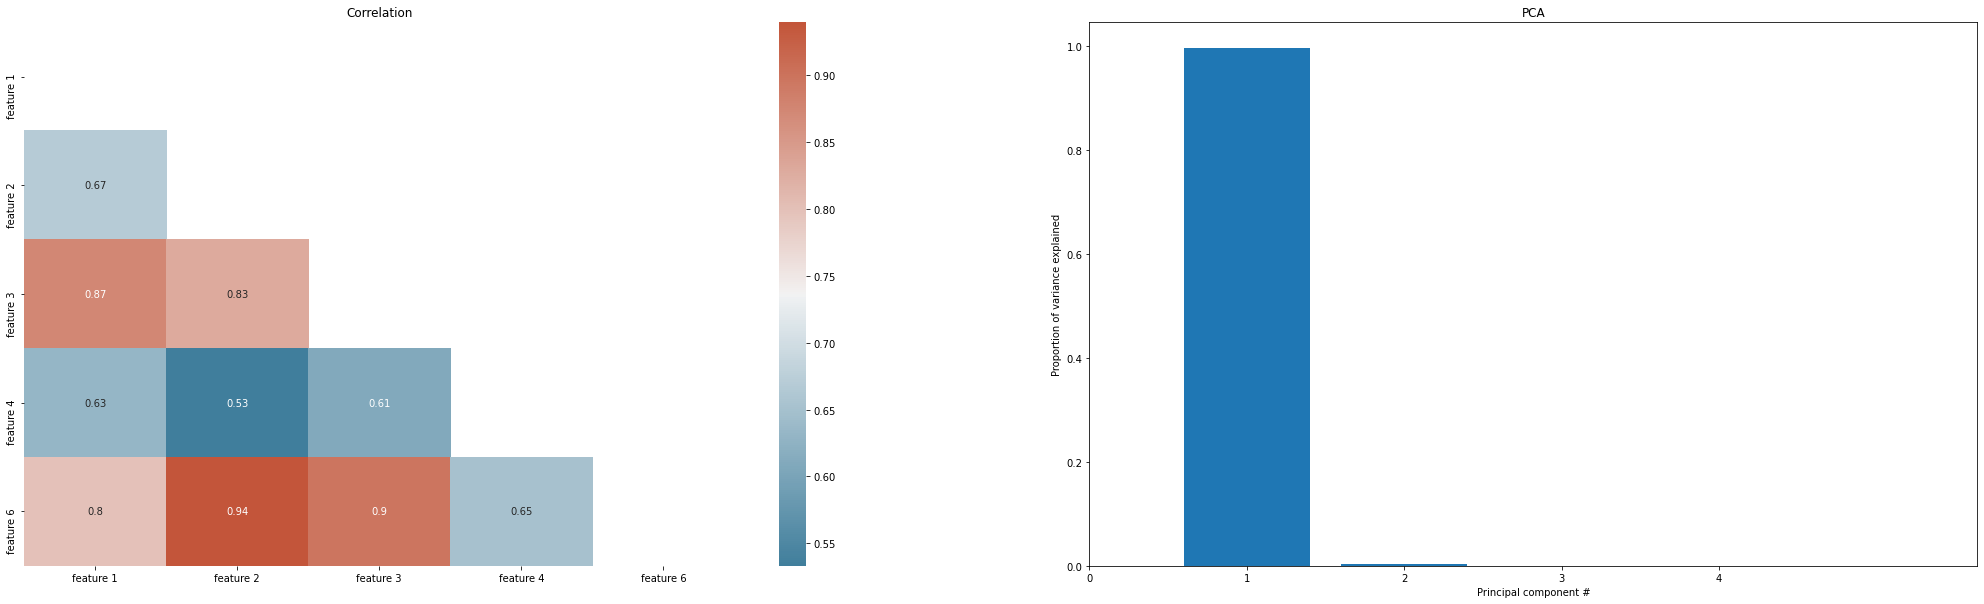

In [15]:
stat_analysis(df_big_chunk[best_features_big].iloc[:,:], 2)

The cumulative variance of the first 2 principal components is 1.0


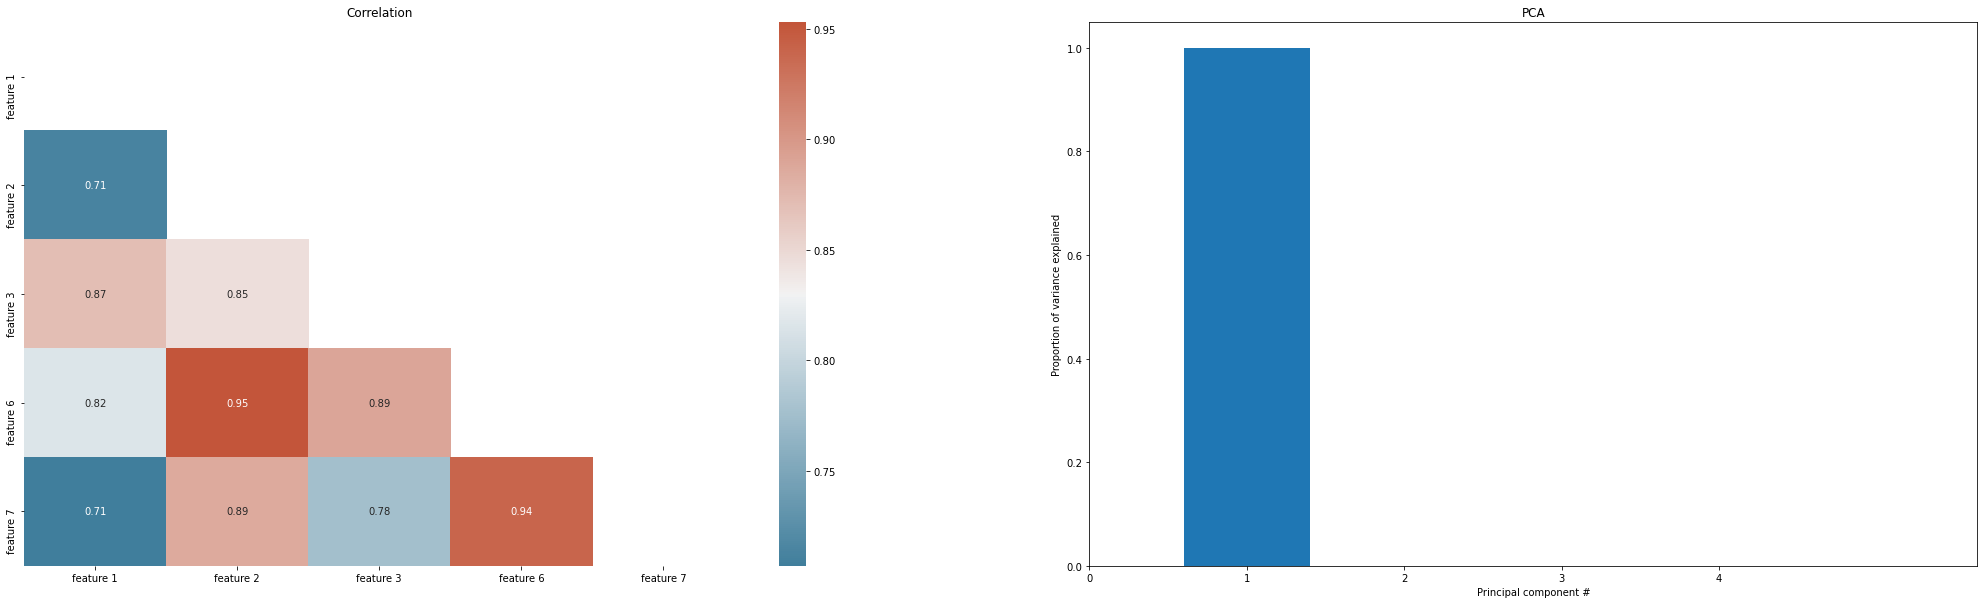

In [16]:
stat_analysis(df_small_chunk[best_features_small].iloc[:,:], 2)

- We notice that we can retrieve most of our data's information at 2 pca components

-----

-----

## Save Data

In [17]:
depended_features_small = np.savetxt("A:\OpenSesame\data\\speaker_features_small.csv", best_features_small, delimiter =", ", fmt ='% s')
depended_features_big = np.savetxt("A:\OpenSesame\data\\speaker_features_big.csv", best_features_big, delimiter =", ", fmt ='% s')

In [18]:
df_big_chunk[best_features_big].to_csv('A:\OpenSesame\data\\big_chunk_speaker.csv', index=False)
df_small_chunk[best_features_small].to_csv('A:\OpenSesame\data\\small_chunk_speaker.csv', index=False)
df_big_chunk['speaker'].to_csv('A:\OpenSesame\data\\target_data_speaker.csv', index=False)

After exporting our data lets go for our model building notebook.